In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 21.3 MB/s eta 0:00:00


In [3]:
from pycocotools.coco import COCO
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torchvision.io as io
import random
import torchvision.transforms as tf
import pandas as pd
import cv2
from tqdm import tqdm
from copy import deepcopy
import torch.nn as nn
import torchvision
import torchvision.transforms.functional as F
from torch.autograd import Variable
from torch.utils.data.sampler import RandomSampler
from torchmetrics import JaccardIndex
from torch.nn.functional import one_hot
from tqdm import tqdm

In [4]:
train_annotations = COCO("/content/drive/MyDrive/Med/data_injured/labels.json")

cat_ids = train_annotations.getCatIds(catNms=["Asept", "Bacterial", "Gnoy"])
train_img_ids = []
for cat in cat_ids:
    train_img_ids.extend(train_annotations.getImgIds(catIds=cat))
    
train_img_ids = list(set(train_img_ids))
print(f"Number of training images: {len(train_img_ids)}")

loading annotations into memory...
Done (t=0.65s)
creating index...
index created!
Number of training images: 451


In [5]:
class ImageData(Dataset):
    def __init__(
        self, 
        annotations: COCO, 
        img_ids: list[int], 
        cat_ids: list[int], 
        root_path: Path, 
        transform
    ) -> None:
        super().__init__()
        self.annotations = annotations
        self.img_data = annotations.loadImgs(img_ids)
        self.cat_ids = cat_ids
        self.files = [str(root_path + img["file_name"]) for img in self.img_data]
        self.transform = transform
        
    def __len__(self) -> int:
        return len(self.files)
    
    def __getitem__(self, i: int) -> tuple[torch.Tensor, torch.LongTensor]:
        ann_ids = self.annotations.getAnnIds(
            imgIds=self.img_data[i]['id'], 
            catIds=self.cat_ids, 
            iscrowd=None
        )
        anns = self.annotations.loadAnns(ann_ids)
        mask = torch.LongTensor(np.max(np.stack([self.annotations.annToMask(ann) * ann["category_id"] 
                                                 for ann in anns]), axis=0)).unsqueeze(0)
        
        img = io.read_image(self.files[i])
        if img.shape[0] == 1:
            img = torch.cat([img]*3)
        
        if self.transform is not None:
            return self.transform(img, mask)
        
        return img, mask

In [6]:
def encoder(seg_mask):
  num_classes = 3
  #seg_mask = torch.tensor([[0, 1, 2], [1, 0, 2]])  # example segmentation mask
  one_hot_mask = torch.zeros((seg_mask.shape[1], seg_mask.shape[2], num_classes))
  
  for i in range(seg_mask.shape[1]):
    for j in range(seg_mask.shape[2]):
        #print(seg_mask.shape)
        class_value = seg_mask[0][i][j]
        print(class_value)
        one_hot_mask[i][j][class_value] = 1
  one_hot_mask = one_hot_mask.permute(2, 0, 1)

  return one_hot_mask

In [7]:
imgIds_1 = train_annotations.getImgIds(catIds=1)
imgIds_2 = train_annotations.getImgIds(catIds=2)
imgIds_3 = train_annotations.getImgIds(catIds=3)

In [8]:
def train_transform(
    img1: torch.Tensor, 
    img2: torch.Tensor
) -> tuple[torch.Tensor, torch.Tensor]:
    #params = tf.RandomResizedCrop.get_params(img1, scale=(0.5, 1.0), ratio=(0.75, 1.33))

    IMAGE_SIZE = [256, 256]

    #gr2rgb = tf.Lambda(lambda x: x.repeat(3, 1, 1))
    #img2 = gr2rgb(img2)
    
    img1 = tf.functional.resize(img1, size=IMAGE_SIZE)
    img2 = tf.functional.resize(img2, size=IMAGE_SIZE)

    #img2 = encoder(img2)
        
    return img1, img2



In [9]:
train_data = ImageData(train_annotations, train_img_ids, cat_ids, "/content/drive/MyDrive/Med/data_injured/data/", train_transform)
BATCH_SIZE = 30

train_dl = DataLoader(
    train_data,
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True, 
    num_workers=4,
    pin_memory=True,
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


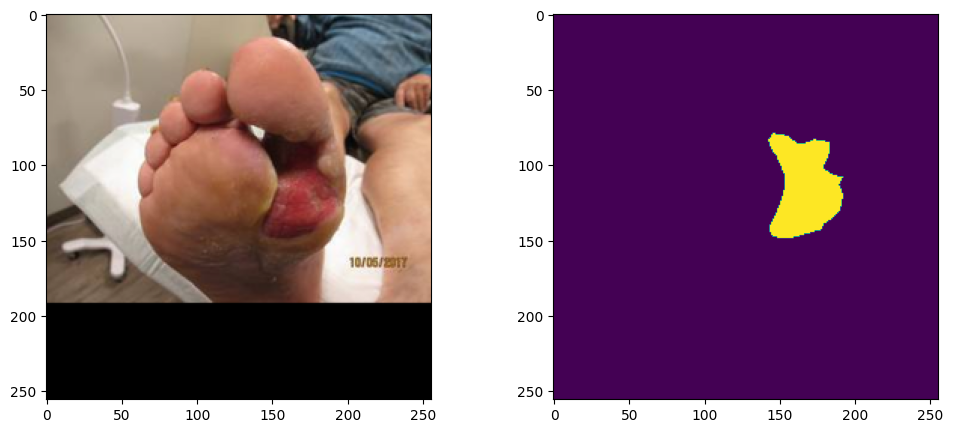

In [10]:
img, mask = train_data[0]
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(tf.functional.to_pil_image(img))
plt.subplot(122)
plt.imshow(tf.functional.to_pil_image(mask.float()))
plt.show()

In [11]:
mask.shape

torch.Size([1, 256, 256])

In [12]:
n_fold = 5
pad_left = 27
pad_right = 27
fine_size = 202
batch_size = 18
epoch = 50 
snapshot = 6 
max_lr = 0.012 
min_lr = 0.001 
momentum = 0.9 
weight_decay = 1e-4 
n_fold = 5
device = torch.device('cuda')
save_weight = 'weights/'
if not os.path.isdir(save_weight):
  os.mkdir(save_weight)
weight_name = 'model_' + str(fine_size+pad_left+pad_right) + '_res18' 

In [13]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [14]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [15]:
def train(train_loader, model, optimizer):
  running_loss = 0.0
  data_size = len(train_data)

  model.train()
  predicts = []
  truths = []

  for inputs, masks in tqdm(train_loader):
    #print(inputs.shape)
    #print(masks.shape)
    inputs, masks = inputs.to(device), masks.to(device)
    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
      inputs = inputs.float()
      masks = masks
      masks = masks.squeeze()
      logit = model(inputs)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(logit, masks)
      loss.backward()
      optimizer.step()

    predicts.append(torch.softmax(logit, dim=0).detach().cpu().numpy()) 
    truths.append(masks.detach().cpu().numpy())

    #predicts = np.concatenate(predicts).squeeze()
    #truths = np.concatenate(truths).squeeze()

    running_loss += loss.item() * inputs.size(0)

  predicts = np.concatenate(predicts).squeeze()
  truths = np.concatenate(truths).squeeze()

  jaccard = JaccardIndex(num_classes=4, task="multiclass")

  iou = jaccard(torch.tensor(predicts), torch.tensor(truths))

  epoch_loss = running_loss / data_size
  return epoch_loss, iou



In [16]:
unet = UNet(3, 4)
unet.to(device)
optimizer = torch.optim.SGD(unet.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
# Setup optimizer
scheduler_step = 100
optimizer = torch.optim.SGD(unet.parameters(), lr=max_lr, momentum=momentum, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, scheduler_step, min_lr)


num_snapshot = 0
best_iou = 0

for epoch_ in range(epoch):
  train_loss, iou = train(train_dl, unet, optimizer)
  lr_scheduler.step()

  if iou > best_iou:
    best_iou = iou
    best_param = unet.state_dict()

  if epoch_ == epoch-1:
    torch.save(best_param, save_weight + weight_name + str(num_snapshot) + '.pth')

  print('epoch: {} train_loss: {:.3f} iou: {:.3f}'.format(epoch_ + 1, train_loss, iou))

100%|██████████| 15/15 [00:53<00:00,  3.60s/it]


epoch: 1 train_loss: 0.496 iou: 0.084


100%|██████████| 15/15 [00:26<00:00,  1.78s/it]


epoch: 2 train_loss: 0.053 iou: 0.107


100%|██████████| 15/15 [00:25<00:00,  1.72s/it]


epoch: 3 train_loss: 0.047 iou: 0.107


100%|██████████| 15/15 [00:26<00:00,  1.75s/it]


epoch: 4 train_loss: 0.043 iou: 0.110


100%|██████████| 15/15 [00:25<00:00,  1.71s/it]


epoch: 5 train_loss: 0.041 iou: 0.108


100%|██████████| 15/15 [00:26<00:00,  1.74s/it]


epoch: 6 train_loss: 0.040 iou: 0.105


100%|██████████| 15/15 [00:26<00:00,  1.80s/it]


epoch: 7 train_loss: 0.038 iou: 0.103


100%|██████████| 15/15 [00:26<00:00,  1.73s/it]


epoch: 8 train_loss: 0.037 iou: 0.105


  7%|▋         | 1/15 [00:03<00:45,  3.28s/it]


KeyboardInterrupt: ignored

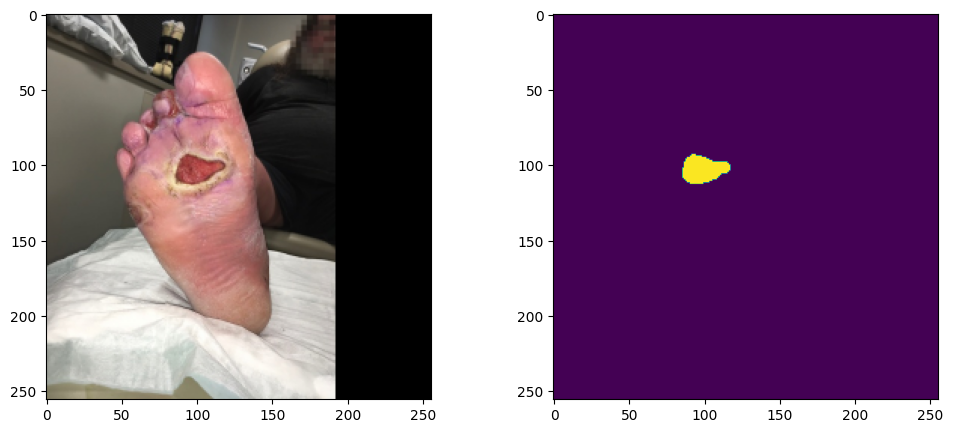

In [50]:
img, mask = train_data[205]
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(tf.functional.to_pil_image(img))
plt.subplot(122)
plt.imshow(tf.functional.to_pil_image(mask.float()))
plt.show()

torch.Size([4, 256, 256])


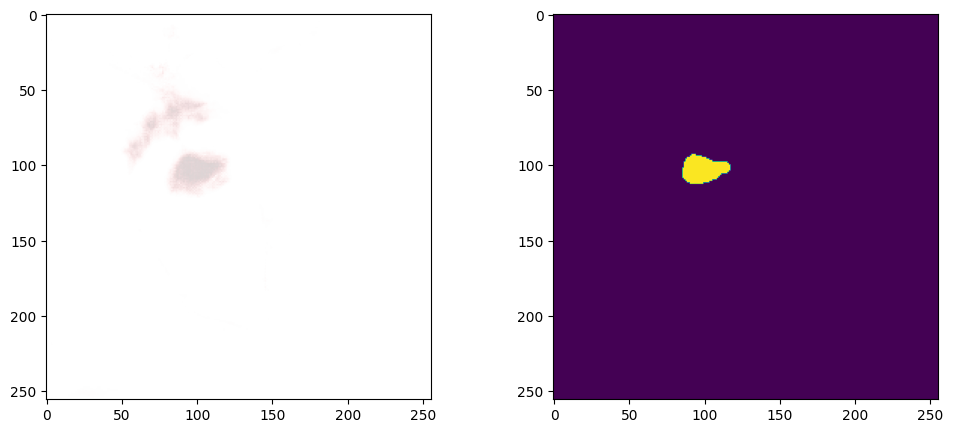

In [51]:
outputs = unet(img.to(device).float().reshape(1, 3, 256, 256))
img_out = torch.softmax(outputs.squeeze(), dim=0)
print(img_out.shape)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(tf.functional.to_pil_image(img_out))
plt.subplot(122)
plt.imshow(tf.functional.to_pil_image(mask.float()))
plt.show()

In [52]:
img_out[0]

tensor([[0.9964, 0.9991, 0.9994,  ..., 0.9962, 0.9955, 0.9972],
        [0.9922, 0.9990, 0.9998,  ..., 0.9991, 0.9984, 0.9983],
        [0.9937, 0.9983, 0.9982,  ..., 0.9995, 0.9987, 0.9985],
        ...,
        [0.9979, 0.9996, 0.9991,  ..., 0.9998, 0.9991, 0.9987],
        [0.9987, 0.9996, 0.9964,  ..., 0.9996, 0.9984, 0.9989],
        [0.9966, 0.9979, 0.9964,  ..., 0.9976, 0.9978, 0.9976]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [53]:
img_out[1][100][100]

tensor(0.1671, device='cuda:0', grad_fn=<SelectBackward0>)

In [54]:
img_out[2][100][100]

tensor(0.1961, device='cuda:0', grad_fn=<SelectBackward0>)

In [55]:
img_out[3][100][100]

tensor(0.2039, device='cuda:0', grad_fn=<SelectBackward0>)

In [56]:
mask[0][100][100]

tensor(2)